# Starbucks Offer Response Analysis

## Project Overview

Starbucks sends out offers to customers through various media channels to encourage buying. The offers can be discount coupons or  merely advertisements for specific drinks. However, only a proportion of the sent-out offers are viewed and used by the customers before expiration. The demographic characteristics of a customer, as well as the features of the received offer, may affect the way that they react to the offer. Sending out the offers in a smarter way may improve the effectiveness and stimulate more buying.

To better understand the target audience of different offer types, a simulation is conducted to mimic customer behavior on the Starbucks offers. The offers include BOGO (buy one get one), discounts, and informational ads. During the 30-day experiment, customers may receive offers every few days. Some users might not receive any offer during certain weeks and not all users receive the same offer. 
The available data contain the offer portfolio, the customer profile, and the transaction information. The objective is to explore a smarter way to send out offers that gains a higher response rate.

## Problem Statement

The primary issues that the project focuses on are

- what factors have the most important impacts on the response from customers,

- which demographic groups respond best to which offer type.

## Evaluation Metrics

The project first conducts qualitative analysis that provides a set of heuristics, then trains a machine learning model that provides quantitative results. Two metrics being used are F1 score and feature importance, the former of which measures the accuracy of a model, and the latter of which gives us a sense of the predictive power of the features in the model.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
import string
import datetime

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import normalize
import matplotlib.ticker as mtick

pd.options.mode.chained_assignment = None
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Analysis

### Data Overview

In this part, we will first have an overview of each dataset and determine the data cleaning and processing steps.

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

#### Portfolio of Offers

In [2]:
portfolio.head(3)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed


In [3]:
portfolio.groupby(['offer_type'])['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

In [4]:
portfolio['channels'].values

array([list(['email', 'mobile', 'social']),
       list(['web', 'email', 'mobile', 'social']),
       list(['web', 'email', 'mobile']), list(['web', 'email', 'mobile']),
       list(['web', 'email']), list(['web', 'email', 'mobile', 'social']),
       list(['web', 'email', 'mobile', 'social']),
       list(['email', 'mobile', 'social']),
       list(['web', 'email', 'mobile', 'social']),
       list(['web', 'email', 'mobile'])], dtype=object)

There are four types of media channels that the offers are sent through. The ```channels``` column will be split into four columns, each of which is a binary categorical column corresponding to a channel. This will be done in the data processing part.

#### Profile of Users

In [5]:
profile.head(3)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN


In [6]:
# check missing values
profile.isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [7]:
print('The proportion of records with missing values: ', 2175/len(profile))

The proportion of records with missing values:  0.12794117647058822


Check the ```gender``` column.

Only around 1% of records have a gender other than female ('F') and male ('M'), which is denoted as 'O' in the dataset. Keeping these records will make the dataset severely imbalanced and affect the model performance. So these records will be dropped when doing data processing.

In [8]:
profile['gender'].unique()

array([None, 'F', 'M', 'O'], dtype=object)

In [9]:
print('The proportion of records with \'O\' gender: ',
      sum(profile['gender'] == 'O')/len(profile))

The proportion of records with 'O' gender:  0.012470588235294117


Check ```age``` column.

The maximum age is 118, which indicates a missing value. These records will be dropped in data processing.

In [10]:
# statistics of 'age' column
profile['age'].describe()

count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

#### Transcript

In [11]:
transcript.head(3)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0


In [12]:
transcript.shape

(306534, 4)

In [13]:
transcript.dtypes

person    object
event     object
value     object
time       int64
dtype: object

In [14]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [15]:
# check missing values
transcript.isna().sum()

person    0
event     0
value     0
time      0
dtype: int64

There are no missing values and abnormal records in the transcript dataset. This dataset is split into four subsets depending on the type of event. But the ```value``` column is in dictionary form, which need to be encoded in data processing.

### Data Cleaning

Since there is no missing values and abnormalities in portfolio and transcript datasets, we only need to clean the profile data before moving forward. The cleaning steps are:
 - Drop records with missing values in ```gender```, ```Income``` and ```age``` columns.
 - Drop records that ```gender = 'O'```

In [16]:
# drop missing values
profile.dropna(subset = ['gender', 'income'], inplace = True)
profile = profile[profile['age'] != 118]

# drop gender = 'O' records
profile = profile[profile['gender'] != 'O']

Now we can have an overview of the customers' demographic distribution. The median age is around 50s-60s and the median income is around 60k.

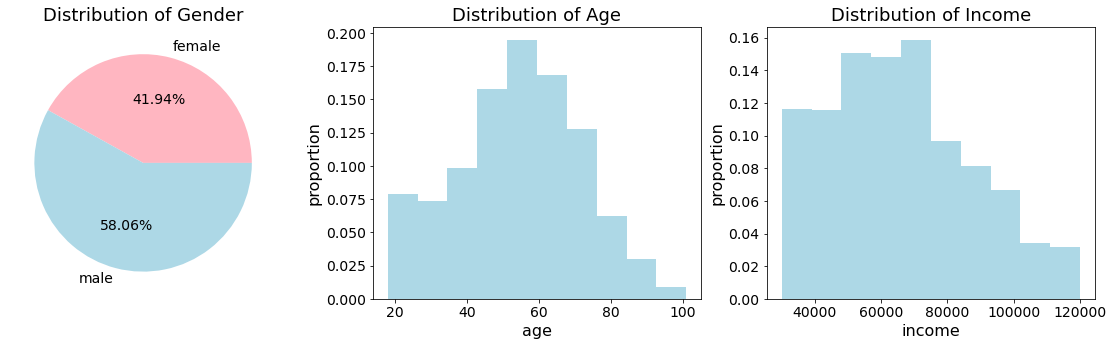

In [17]:
fig = plt.figure(figsize = (20, 5))
axs = []

gender = profile.groupby('gender')['id'].count().reset_index(name = 'gender_count')
axs.append(fig.add_subplot(131))
axs[0].pie(gender['gender_count'], labels = ['female', 'male'],
          autopct = '%.2f%%', colors = ['lightpink', 'lightblue'], textprops={'fontsize': 14})
plt.title('Distribution of Gender', fontsize = 18)


# the distribution of the age
axs.append(fig.add_subplot(132))
age = profile['age']
axs[1].hist(age, bins = 10, weights = np.ones_like(age)/len(age),
        color = 'lightblue')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('age', fontsize = 16)
plt.ylabel('proportion', fontsize = 16)
plt.title('Distribution of Age', fontsize = 18)

# the distribution of the income
axs.append(fig.add_subplot(133))
income = profile['income']
axs[2].hist(income, bins = 10, weights = np.ones_like(age)/len(age),
        color = 'lightblue')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('income', fontsize = 16)
plt.ylabel('proportion', fontsize = 16)
plt.title('Distribution of Income', fontsize = 18)

plt.show()

### Data Processing

In this part, we will encode categorical variables in each dataset, merge/split the datasets and select/create features to get the data we need to do further analysis and modeling:

- Encode categorical features.
    - Profile data: encode gender.
    - Portfolio data: split ```channels``` column into four separate categorical columns.
    
- Convert ```duration``` in ```portfolio``` to hours.
    
- Process ```transcript``` dataframe.
    - Split the dataset into four subset by ```event```. The four new dataframes are named ```received```, ```viewed```, ```completed``` and ```transaction```.
    - Extract offer id from ```value``` column in ```received```, ```viewed``` and ```completed``` and store in a new column named ```offer```.
    - Extract the transaction amount from the ```value``` column in ```transaction``` subset and store the amount to a new column.
    
- Merge and split dataset.
    - Merging ```profile``` to ```received``` by customer id.
    - Merge ```portfolio``` to ```received``` dataframe by offer id.
    - Split the merged dataset by offer type into 3 new dataframes.

- Add new features/columns.
    - Check if an offer is viewed and add a new column named ```viewed``` in ```received```.
    - Check if an offer is completed and add a new column named ```completed``` in ```received```
    - Add the number of days that a customer has become a member.
    - Add an ```amount (offer)``` column to ```profile_sub``` dataset, which is the amount a customer spend within offer active windows.
    - Add an ```amount (no offer)``` column to ```profile_sub``` dataset, which is the amount a customer spend with no offer. We only keep the customers who have ever received an offer in this case.

#### Encode categorical features

Encode ```gender``` in profile.

In [18]:
# encode gender in profile
gender_dict = {'F': 1, 'M': 0}
profile['gender'] = profile['gender'].apply(lambda x: gender_dict[x])

Split `channels` into separate category columns

In [19]:
channels = pd.Series(['web', 'email', 'social', 'mobile'])

def get_channels(val, channels = channels):
    """
    Encode the channels column from a list of strings to a 
    list of 0s and 1s.
    
    Args:
        val: a list of channels extracted from the dataframe
        channels: a series of all alternative channels
        
    Return:
        encoded_channels: a list of 0s and 1s 
        indicating which channels occur in the input value.
    """
    val = pd.Series(val)
    encoded_channels = channels.isin(val).astype("int").tolist()
    return encoded_channels

portfolio['encoded_channels'] = portfolio['channels'].apply(lambda x: get_channels(x))

In [20]:
# split the channels into separate columns
portfolio[['web', 'email', 'social', 'mobile']] = pd.DataFrame(portfolio.encoded_channels.tolist())

In [21]:
portfolio.drop(columns = ['channels', 'encoded_channels'], inplace = True)

In [22]:
portfolio.head(3)

,reward,difficulty,duration,offer_type,id,web,email,social,mobile
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1


#### Convert ```duration``` from days to hours

In [23]:
portfolio['duration'] = 24*portfolio['duration']

#### Process the ```transcript``` dataset.

In [24]:
# split the transcript dataset to four subsets by event type
received = transcript[transcript['event'] == 'offer received']
viewed = transcript[transcript['event'] == 'offer viewed']
transaction = transcript[transcript['event'] == 'transaction']
completed = transcript[transcript['event'] == 'offer completed']

In [25]:
# get offer id/transaction amount from value column
received['offer'] = received['value'].apply(lambda x: x['offer id'])
received.rename(columns = {'time': 'received time'}, inplace = True)

viewed['offer'] = viewed['value'].apply(lambda x: x['offer id'])
viewed.rename(columns = {'time': 'viewed time'}, inplace = True)

transaction['amount'] = transaction['value'].apply(lambda x: x['amount'])
transaction.rename(columns = {'time': 'transaction time'}, inplace = True)

completed['offer'] = completed['value'].apply(lambda x: x['offer_id'])
completed['act_reward'] = completed['value'].apply(lambda x: x['reward'])
completed.rename(columns = {'time': 'completed time'}, inplace = True)

In [26]:
received.drop(columns = ['value', 'event'], inplace = True)
viewed.drop(columns = ['value', 'event'], inplace = True)
transaction.drop(columns = ['value', 'event'], inplace = True)
completed.drop(columns = ['value', 'event'], inplace = True)

#### Add ```membership days``` to ```profile``` dataframe.

In [27]:
# consider the latest date that can be found in the become_a_member column
# as the current date
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format = '%Y%m%d')
profile['became_member_on'].max(), profile['became_member_on'].min()

(Timestamp('2018-07-26 00:00:00'), Timestamp('2013-07-29 00:00:00'))

In [28]:
# add the number of days a customer has become a member
latest_date = datetime.datetime.strptime('2018-07-26', '%Y-%m-%d')
profile['membership days'] = profile['became_member_on'].apply(lambda x: (latest_date - x).days)

#### Merge and Split dataframes

In [29]:
# merge the customer profile data and the offer portfolio data in
offers = pd.merge(received, portfolio, left_on = 'offer', right_on = 'id')
offers = pd.merge(offers, profile, left_on = 'person', right_on = 'id')
offers.drop(columns = ['id_x', 'id_y'], inplace = True)

In [30]:
offers.head(3)

,person,received time,offer,reward,difficulty,duration,offer_type,web,email,social,mobile,gender,age,became_member_on,income,membership days
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,168,bogo,1,1,0,1,1,75,2017-05-09,100000.0,443
1,78afa995795e4d85b5d9ceeca43f5fef,504,f19421c1d4aa40978ebb69ca19b0e20d,5,5,120,bogo,1,1,1,1,1,75,2017-05-09,100000.0,443
2,78afa995795e4d85b5d9ceeca43f5fef,408,ae264e3637204a6fb9bb56bc8210ddfd,10,10,168,bogo,0,1,1,1,1,75,2017-05-09,100000.0,443


In [31]:
# split all received offers to BOGO, discount and informational subsets
bogo = offers[offers['offer_type'] == 'bogo']
bogo.reset_index(inplace = True)

discount = offers[offers['offer_type'] == 'discount']
discount.reset_index(inplace = True)

info = offers[offers['offer_type'] == 'informational']
info.reset_index(inplace = True)

#### Check if an offer was viewed or not. Add ```viewed``` column to ```received``` dataframe.

In [32]:
def add_view(offers, viewed):
    """
    Check if an offer was viewed by the customer who received it.
    
    Args: 
        offers - a dataframe that contains all offers that all customers received
        viewed - a dataframe that contains the records of the offers that were
                 viewed by customers
                 
    Returns:
        offers - the input dataframe with a new column added, which named 'viewed'
                 and indicate whether the corresponding record was viewd by customer
                 or not
    """
    
    offers['viewed time'] = None
    offers['viewed'] = False

    for i in range(0, len(offers)):
        person, offer, t1, duration = offers.iloc[i,:][['person', 'offer', 'received time', 'duration']]
        t2 = t1 + duration
        # only offers that were viewed before expiration are considered viewed offers
        viewed_records = viewed[(viewed['person'] == person) & (viewed['offer'] == offer) &
                         (viewed['viewed time'] >= t1) & (viewed['viewed time'] <= t2)]
        
        if len(viewed_records) > 0:
            offers.loc[i, 'viewed time'] = viewed_records.iloc[0,:]['viewed time']
            offers.loc[i, 'viewed'] = True

    return offers

In [33]:
# add viewed column to the three subsets
bogo_viewed = viewed[viewed[['person','offer']].apply(tuple, axis=1)\
                  .isin(bogo[['person','offer']].apply(tuple, axis=1))]
bogo = add_view(bogo, bogo_viewed)

discount_viewed = viewed[viewed[['person','offer']].apply(tuple, axis=1)\
                  .isin(discount[['person','offer']].apply(tuple, axis=1))]
discount = add_view(discount, discount_viewed)

info_viewed = viewed[viewed[['person', 'offer']].apply(tuple, axis = 1)\
                    .isin(info[['person', 'offer']].apply(tuple, axis = 1))]
info = add_view(info, info_viewed)

In [34]:
bogo.head()

,index,person,received time,offer,reward,difficulty,duration,offer_type,web,email,social,mobile,gender,age,became_member_on,income,membership days,viewed time,viewed
0,0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,168,bogo,1,1,0,1,1,75,2017-05-09,100000.0,443,6,True
1,1,78afa995795e4d85b5d9ceeca43f5fef,504,f19421c1d4aa40978ebb69ca19b0e20d,5,5,120,bogo,1,1,1,1,1,75,2017-05-09,100000.0,443,582,True
2,2,78afa995795e4d85b5d9ceeca43f5fef,408,ae264e3637204a6fb9bb56bc8210ddfd,10,10,168,bogo,0,1,1,1,1,75,2017-05-09,100000.0,443,408,True
3,4,ebe7ef46ea6f4963a7dd49f501b26779,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,168,bogo,1,1,0,1,0,59,2015-01-21,41000.0,1282,None,False
4,5,ebe7ef46ea6f4963a7dd49f501b26779,576,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,168,bogo,1,1,0,1,0,59,2015-01-21,41000.0,1282,714,True


#### Check if an offer was completed or not. Add ```completed``` column to ```received``` dataframe.

For BOGO and discount, an offer is considered completed if it was viewd and the complete time is later than the viewed time and expiration time.

For informational ads, since there is no minimum consumption amount, an offer is considered completed if it was viewed and there is at least transaction record before the expiration.

In [35]:
def add_complete(offers, completed):
    """
    Check if a BOGO/discount offer was completed by the customer who received it.
    
    Args: 
        offers - a dataframe that contains all BOGO/discount offers that all customers received
        completed - a dataframe that contains the records of the offers that got the
                 minimum amount required to complete the corresponding offers
                 
    Returns:
        offers - the input dataframe with a new column added, which named 'completed'
                 and indicate whether the corresponding record was completed by customer
                 or not
    """
    
    offers['completed time'] = None
    offers['completed'] = False
    
    for i in range(0, len(offers)):
        # only for viewed offers
        if offers.iloc[i, :]['viewed']:
            person, offer, t1, duration, viewed_time = offers.iloc[i,:][['person', 'offer', 'received time', 'duration', 'viewed time']]
            t2 = t1 + duration
            # only offers that were viewed and completed before expiration 
            # are considered completed offers
            completed_records = completed[(completed['person'] == person) & (completed['offer'] == offer) &
                             (completed['completed time'] <= t2) & (completed['completed time'] >= viewed_time)]
        
            if len(completed_records) > 0:
                offers.loc[i, 'completed time'] = completed_records.iloc[0,:]['completed time']
                offers.loc[i, 'completed'] = True

    return offers

In [36]:
# add complete column to BOGO and discount subsets
bogo_cmplt = completed[completed[['person','offer']].apply(tuple, axis=1)\
                  .isin(bogo[['person','offer']].apply(tuple, axis=1))]
bogo = add_complete(bogo, bogo_cmplt)

discount_cmplt = completed[completed[['person','offer']].apply(tuple, axis=1)\
                  .isin(discount[['person','offer']].apply(tuple, axis=1))]
discount = add_complete(discount, discount_cmplt)

In [37]:
bogo.head()

,index,person,received time,offer,reward,difficulty,duration,offer_type,web,email,...,mobile,gender,age,became_member_on,income,membership days,viewed time,viewed,completed time,completed
0,0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,168,bogo,1,1,...,1,1,75,2017-05-09,100000.0,443,6,True,132,True
1,1,78afa995795e4d85b5d9ceeca43f5fef,504,f19421c1d4aa40978ebb69ca19b0e20d,5,5,120,bogo,1,1,...,1,1,75,2017-05-09,100000.0,443,582,True,None,False
2,2,78afa995795e4d85b5d9ceeca43f5fef,408,ae264e3637204a6fb9bb56bc8210ddfd,10,10,168,bogo,0,1,...,1,1,75,2017-05-09,100000.0,443,408,True,510,True
3,4,ebe7ef46ea6f4963a7dd49f501b26779,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,168,bogo,1,1,...,1,0,59,2015-01-21,41000.0,1282,None,False,None,False
4,5,ebe7ef46ea6f4963a7dd49f501b26779,576,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,168,bogo,1,1,...,1,0,59,2015-01-21,41000.0,1282,714,True,None,False


In [38]:
def add_complete_info(offers, transactions):
    """
    Check if an informational offer was completed by the customer who received it.
    
    Args: 
        offers - a dataframe that contains all informational offers that all customers received
        transactions - a dataframe that contains all transaction records
        
    Returns:
        offers - the input dataframe with a new column added, which named 'completed'
                 and indicate whether the corresponding record was completed by customer
                 or not
    """
    
    # find transactions happened after the offer was viewed and before the expiration
    offers['amount'] = 0
    offers['completed'] = False
    
    for i in range(0, len(offers)):
        record = offers.iloc[i, :]
        # only for viewed offers
        if record['viewed']:
            person, received, viewed, duration = record['person'], record['received time'], record['viewed time'], record['duration']

            # transactions finished by the user
            trans_rec = transactions[transactions['person'] == person]

            if record['viewed'] and len(trans_rec) > 0:
                # completed transactions in the offer time window
                trans_rec = trans_rec[(trans_rec['transaction time'] >= viewed) & 
                                     (trans_rec['transaction time'] <= received + duration)]
                if len(trans_rec) > 0:
                    offers.loc[i, 'completed'] = True
                    offers.loc[i, 'amount'] += np.sum(trans_rec['amount'].values)
    
    return offers

In [39]:
# extract transactions finished only by users who got informational offers
trans_info = transaction[transaction['person'].isin(info['person'])]
# add completed column to info subset
info = add_complete_info(info, trans_info)

In [40]:
info.head()

,index,person,received time,offer,reward,difficulty,duration,offer_type,web,email,...,mobile,gender,age,became_member_on,income,membership days,viewed time,viewed,amount,completed
0,3,78afa995795e4d85b5d9ceeca43f5fef,168,5a8bc65990b245e5a138643cd4eb9837,0,0,72,informational,0,1,...,1,1,75,2017-05-09,100000.0,443,216,True,49.39,True
1,8,ebe7ef46ea6f4963a7dd49f501b26779,336,5a8bc65990b245e5a138643cd4eb9837,0,0,72,informational,0,1,...,1,0,59,2015-01-21,41000.0,1282,342,True,7.72,True
2,9,ebe7ef46ea6f4963a7dd49f501b26779,504,5a8bc65990b245e5a138643cd4eb9837,0,0,72,informational,0,1,...,1,0,59,2015-01-21,41000.0,1282,546,True,2.32,True
3,15,f082d80f0aac47a99173ba8ef8fc1909,168,5a8bc65990b245e5a138643cd4eb9837,0,0,72,informational,0,1,...,1,0,40,2016-07-09,33000.0,747,228,True,0.00,False
4,20,c0d210398dee4a0895b24444a5fcd1d2,504,3f207df678b143eea3cee63160fa8bed,0,0,96,informational,1,1,...,1,0,45,2018-07-07,33000.0,19,522,True,11.25,True


#### Add transaction amount during and beyond the offer active time window.

We are only interested in the customers who have ever received offers, which is a subset of the customers in ```profile``` dataset.

In [41]:
def add_transaction(offers, transaction, profile):
    """
    Add the amount that the customer spend when there was an active offer, 
    and the amount that the customer spend when there was no active offer.
    
    Args:
        offers - a dataframe that contains offers completed by customers
        transaction - a dataframe that contains all transactions made by customers
        profile - a dataframe that contains the profile of customers who have ever
                  received offers
                  
    Returns:
        profile - the input dataframe with two new columns. "amount (offer)" is the
                  amount a customer spend for an offer; "amount (no offer)" is the 
                  amount a customer spend without an offer.
    """
    
    profile['amount (offer)'] = 0
    profile['amount (no offer)'] = 0
    
    for i in range(len(profile)):
        person = profile.iloc[i, :]['id']
        transaction_i = transaction[transaction['person'] == person]
        completed_i = offers[offers['person'] == person]
        offer_windows = completed_i[['viewed time', 'completed time']].values
        
        if len(transaction_i) > 0:
            # check if a transaction is within the window of a completed offer
            for j in range(len(transaction_i)):
                boolean = False
                transaction_time = transaction_i.iloc[j, :]['transaction time']
                transaction_amount = transaction_i.iloc[j, :]['amount']
                for window in offer_windows:
                    if transaction_time >= window[0] and transaction_time <= window[1]:
                        profile.loc[i, 'amount (offer)'] += transaction_amount
                        boolean = True
                        break
                if not boolean:
                    profile.loc[i, 'amount (no offer)'] += transaction_amount
                    
    return profile

In [42]:
# all completed records
bogo_cmplt = bogo[bogo['completed'] == 1]
discount_cmplt = discount[discount['completed'] == 1]
info_cmplt = info[info['completed'] == 1]
cmplt_sub = pd.concat([bogo_cmplt, discount_cmplt, info_cmplt])

profile.reset_index(inplace = True)
profile_sub = profile[profile['id'].isin(received['person'])]
profile_sub.reset_index(inplace = True)
profile_sub = add_transaction(cmplt_sub, transaction, profile_sub)
profile_sub.head()

,level_0,index,gender,age,id,became_member_on,income,membership days,amount (offer),amount (no offer)
0,0,1,1,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,376,0.00,77.01
1,1,3,1,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,443,41.61,117.66
2,2,5,0,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,91,18.42,39.31
3,3,8,0,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,167,36.43,0.00
4,4,12,0,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,257,12.43,3.19


### Exploratory Data Analysis

Before diving into the mathematical modeling, we can perform some qualitative exploratory data analysis. This may provide us with takeaways for answering the questions we are interested in.

In this experiment, the number of released information offers is less than the BOGO and discount offers. The completion rate of the offers is less than 50%.

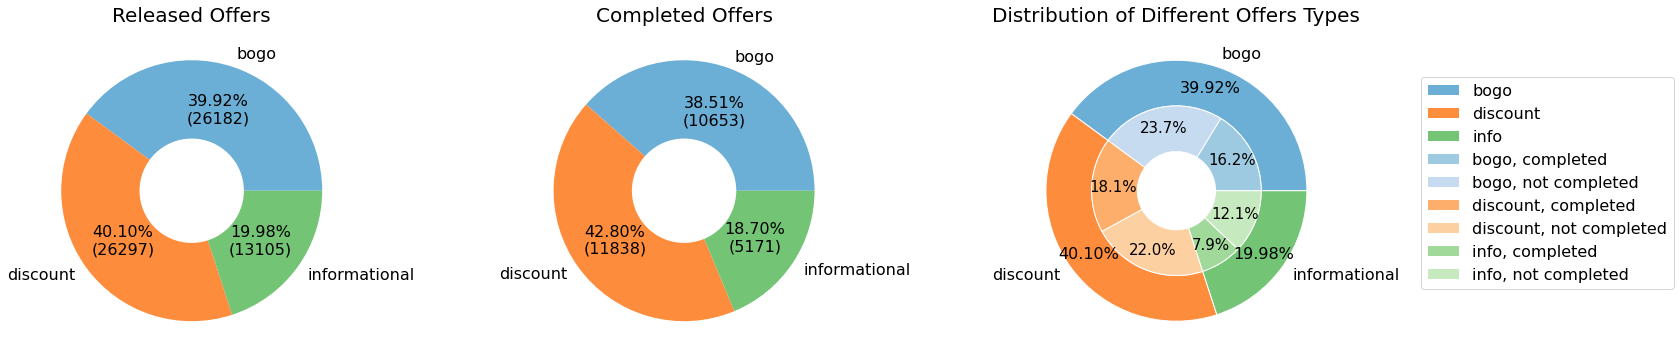

In [43]:
fig = plt.figure(figsize = (25, 6))
axs = []

def my_fmt_1(x):
    """formater of values in pie chart"""
    return '{:.2f}%\n({:0g})'.format(x, int(x*len(offers)/100))

def my_fmt_2(x):
    """formater of values in pie chart"""
    return '{:.2f}%\n({:0g})'.format(x, int(x*sum(cmplt_type)/100))

cmap = plt.get_cmap('tab20c')


# plot the number of release offers of each type in proportion to the total
# number of released offers
axs.append(fig.add_subplot(131))
offer_type = offers.groupby(['offer_type'])['person'].count().reset_index(name = 'count')
axs[0] = plt.pie(offer_type['count'], labels = offer_type['offer_type'], 
                 colors = [cmap(1), cmap(5), cmap(9)], autopct = my_fmt_1, 
                 textprops={'fontsize': 16}, pctdistance = 0.65)
centre_circle1 = plt.Circle((0, 0), 0.4, fc = 'white')
plt.gcf().gca().add_artist(centre_circle1)
plt.title('Released Offers', fontsize = 20)


# plot the number of completed offers of each type in proportion to the total
# number of completed offers
cmplt_type = [sum(bogo['completed']), sum(discount['completed']), sum(info['completed'])]
labels = ['bogo', 'discount', 'informational']

axs.append(fig.add_subplot(132))
axs[1] = plt.pie(cmplt_type, labels = labels, autopct = my_fmt_2, 
                 colors = [cmap(1), cmap(5), cmap(9)], textprops={'fontsize': 16}, pctdistance = 0.65)
centre_circle2 = plt.Circle((0, 0), 0.4, fc = 'white')
plt.gcf().gca().add_artist(centre_circle2)
plt.title('Completed Offers', fontsize = 20)


# integrate the first and the second plot
axs.append(fig.add_subplot(133))
size = 0.35
vals = np.array([[sum(bogo['completed']), len(bogo) - sum(bogo['completed'])],
                [sum(discount['completed']), len(discount) - sum(discount['completed'])],
                [sum(info['completed']), len(info) - sum(info['completed'])]])

outer_colors = cmap(np.arange(3)*4+1)
inner_colors = cmap(np.array([2, 3, 6, 7, 10, 11]))

axs[2].pie(vals.sum(axis = 1), radius = 1, labels = ['bogo', 'discount', 'informational'], labeldistance = 1.1,
        autopct = '%.2f%%', pctdistance = 0.83, colors = outer_colors, 
           textprops={'fontsize': 16}, wedgeprops = dict(width = size, edgecolor = 'w'))
axs[2].pie(vals.flatten(), radius = 1-size, autopct = '%.1f%%',
        colors = inner_colors, wedgeprops = dict(width=size, edgecolor = 'w'), 
           pctdistance = 0.75, textprops={'fontsize': 15})
# axs[2].set(aspect = 'equal')
plt.title('Distribution of Different Offers Types', fontsize = 20)
labels = ['bogo', 'discount', 'info', 'bogo, completed', 'bogo, not completed', 
          'discount, completed', 'discount, not completed', 'info, completed', 'info, not completed']
axs[2].legend(labels, prop = {'size': 16}, loc = (1.25, 0.2))

plt.show()

The following code plot the gender distribution across different types of offers, completed and not-completed offers.

It turns out that the female tends complete relatively more BOGO and discount offer than male, and inversen for informational offers. This indicates that gender can be selected as a predictor when training a classifier.

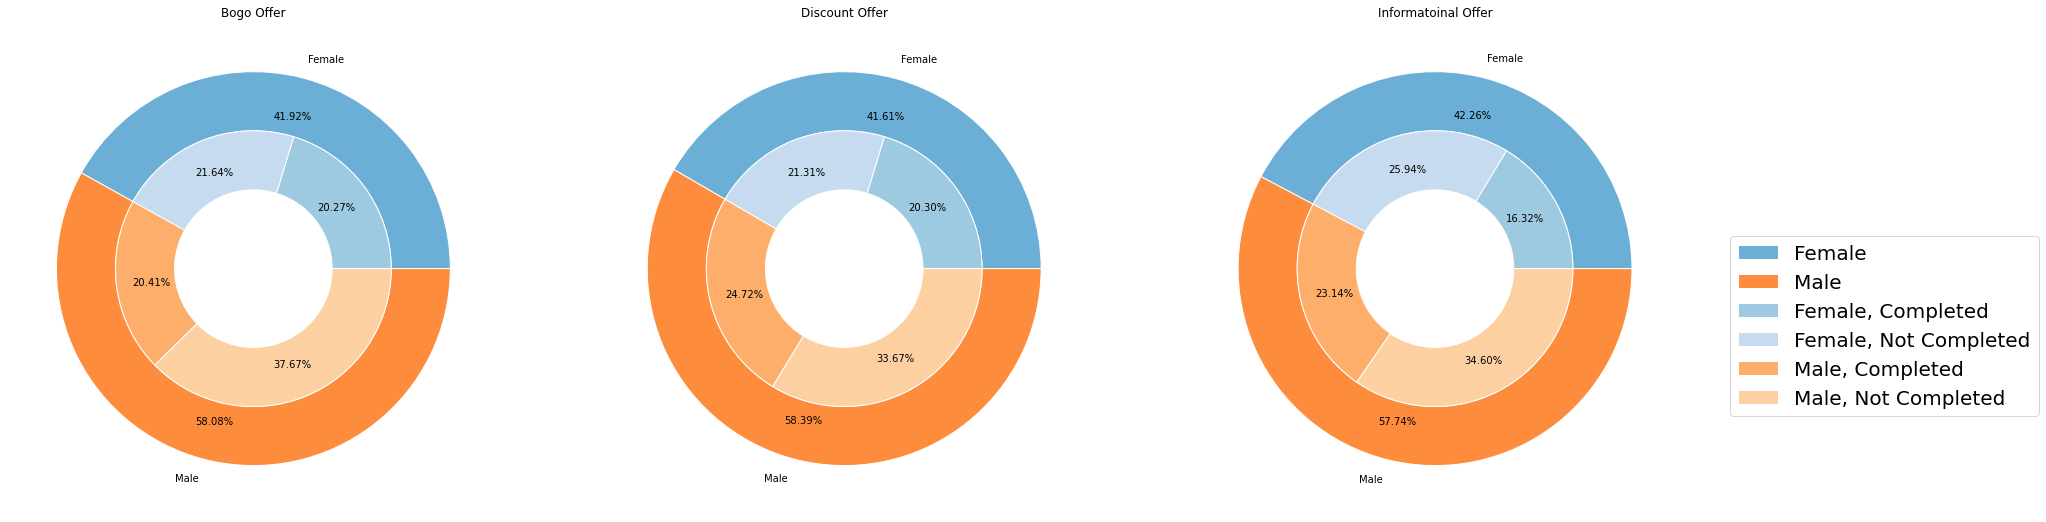

In [44]:
fig = plt.figure(figsize = (30, 10))
axs = []
size = 0.3
cmap = plt.get_cmap('tab20c')
outer_colors = cmap(np.arange(3)*4+1)
inner_colors = cmap(np.array([2, 3, 6, 7, 10, 11]))

# plot gender distribution of customers who received/completed/didn't complete BOGO offer
bogo_f = bogo[bogo['gender'] == 1]
bogo_m = bogo[bogo['gender'] == 0]
bogo_f_y = bogo_f[bogo_f['completed'] == 1]
bogo_m_y = bogo_m[bogo_m['completed'] == 1]

axs.append(fig.add_subplot(131))
vals_bogo = np.array([[len(bogo_f_y), len(bogo_f) - len(bogo_f_y)],
                [len(bogo_m_y), len(bogo_m) - len(bogo_m_y)]])
axs[0].pie(vals_bogo.sum(axis = 1), radius = 1, labels = ['Female', 'Male'], labeldistance = 1.1,
        autopct = '%.2f%%', pctdistance = 0.8, colors = outer_colors, wedgeprops = dict(width = size, edgecolor = 'w'))
axs[0].pie(vals_bogo.flatten(), radius = 1-size, labeldistance = 0.7,
       autopct = '%.2f%%', pctdistance = 0.75, colors = inner_colors, wedgeprops = dict(width=size, edgecolor = 'w'))
axs[0].set(aspect = 'equal', title = 'Bogo Offer')

# plot gender distribution of customers who received/completed/didn't complete discount offer
discount_f = discount[discount['gender'] == 1]
discount_m = discount[discount['gender'] == 0]
discount_f_y = discount_f[discount_f['completed'] == 1]
discount_m_y = discount_m[discount_m['completed'] == 1]

axs.append(fig.add_subplot(132))
vals_discount = np.array([[len(discount_f_y), len(discount_f) - len(discount_f_y)],
                [len(discount_m_y), len(discount_m) - len(discount_m_y)]])
axs[1].pie(vals_discount.sum(axis = 1), radius = 1, labels = ['Female', 'Male'], labeldistance = 1.1,
        autopct = '%.2f%%', pctdistance = 0.8, colors = outer_colors, wedgeprops = dict(width = size, edgecolor = 'w'))
axs[1].pie(vals_discount.flatten(), radius = 1-size, labeldistance = 0.7,
       autopct = '%.2f%%', pctdistance = 0.75, colors = inner_colors, wedgeprops = dict(width=size, edgecolor = 'w'))
axs[1].set(aspect = 'equal', title = 'Discount Offer')

# plot gender distribution of customers who received/completed/didn't complete informational offer
info_f = info[info['gender'] == 1]
info_m = info[info['gender'] == 0]
info_f_y = info_f[info_f['completed'] == 1]
info_m_y = info_m[info_m['completed'] == 1]

axs.append(fig.add_subplot(133))
vals_info = np.array([[len(info_f_y), len(info_f) - len(info_f_y)],
                [len(info_m_y), len(info_m) - len(info_m_y)]])
axs[2].pie(vals_info.sum(axis = 1), radius = 1, labels = ['Female', 'Male'], labeldistance = 1.1,
        autopct = '%.2f%%', pctdistance = 0.8, colors = outer_colors, wedgeprops = dict(width = size, edgecolor = 'w'))
axs[2].pie(vals_info.flatten(), radius = 1-size, labeldistance = 0.7,
        autopct = '%.2f%%', pctdistance = 0.75, colors = inner_colors, wedgeprops = dict(width=size, edgecolor = 'w'))
axs[2].set(aspect = 'equal', title = 'Informatoinal Offer')
labels = ['Female', 'Male', 'Female, Completed', 'Female, Not Completed', 'Male, Completed', 'Male, Not Completed']
axs[2].legend(labels, prop = {'size': 20}, loc = (1.1, 0.2))

plt.show()

Since customers may buy products even though they don't get an offer, a qualitative analysis is conducted for the transactions that contribute to offer completions and those that are not encouraged by the offers. The customers are divided into three groups by income to simplify the analysis.

In [45]:
profile_sub['Income Level'] = 'Under 50k'
profile_sub.loc[(profile_sub['income'] > 50000) & (profile_sub['income'] <= 80000), 
                'Income Level'] = 'Between 50k and 80k'
profile_sub.loc[profile_sub['income'] > 80000, 'Income Level'] = 'Over 80k'

profile_sub = profile_sub[(profile_sub['amount (offer)'] <= 200) &
                         (profile_sub['amount (no offer)'] <= 200)]

profile_sub_1 = profile_sub.drop(columns = ['amount (no offer)'])
profile_sub_1.rename(columns = {'amount (offer)': 'amount'}, inplace = True)
profile_sub_1['type'] = 'offer'

profile_sub_2 = profile_sub.drop(columns = ['amount (offer)'])
profile_sub_2.rename(columns = {'amount (no offer)': 'amount'}, inplace = True)
profile_sub_2['type'] = 'no offer'

profile_sub_type = pd.concat([profile_sub_1, profile_sub_2])

Text(0.5, 1.0, 'Transaction Amount Distribution')

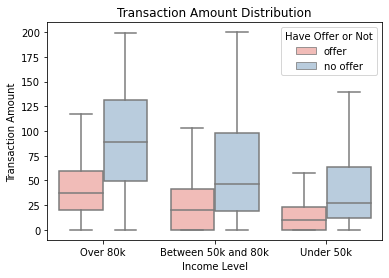

In [46]:
sns.boxplot(x = 'Income Level', y = 'amount', hue = 'type', showfliers = False,
           data = profile_sub_type, palette = 'Pastel1')
plt.legend(title = 'Have Offer or Not', loc = 'upper right')
plt.xlabel('Income Level')
plt.ylabel('Transaction Amount')
plt.title(label = 'Transaction Amount Distribution')

The difference in transaction amount is largest in the group with income over 80k, and smallest in the group with income under 50k. In proportion to the amount they spend with no offer, the offers work more effectively for the customers with lower income.

## Implementation

In this section, a classifier is trained to predict whether a released offer will be completed or not. The classifier chosen in this project is Random Forest. The advantage of Random Forest is that we can get the feature importance from the result. The classifier is trained separately for the three offer types.

#### Get the feature matrix and response variable.

Customer profile features that will be used to train the classifiers include gender, age, income and the number of days being a member. The offer portfolio features include duration, difficulty, reward, social, web, and email are selected as predictors. To avoid the collinearity problem, one of the media channel columns, mobile, is omitted.
The target/label to be predicted is whether the offer is completed, which is stored in the completed column of the received dataset.

In [47]:
feats = ['gender','age', 'income', 'membership days', 'reward', 'difficulty', 'duration', 
         'web', 'email', 'social', 'mobile']

bogo_x, bogo_y = bogo[feats], bogo.loc[:, 'completed']
discount_x, discount_y = discount[feats], discount.loc[:, 'completed']
info_x, info_y = info[feats], info.loc[:, 'completed']

#### Training and test set split

In [48]:
# train and test split
bogo_x_train, bogo_x_test, bogo_y_train, bogo_y_test = train_test_split(bogo_x, bogo_y)
discount_x_train, discount_x_test, discount_y_train, discount_y_test = train_test_split(discount_x, discount_y)
info_x_train, info_x_test, info_y_train, info_y_test = train_test_split(info_x, info_y)

#### Specify a set of hyperparemter values

To refine the performance, the hyperparameters are tuned with ```GridSearchCV```. Predefine values for the number of estimators, the number of features to consider for the best split and the minimum number of sample at leaf node will be passed to the ```GridSearchCV``` function. 

The function will try all combinations of the values and evaluates the model for each combination using cross-validation. The best model with the highest F1 score is returned and considered as the final result.

In [49]:
# parameters to be tuned
parameters = {'n_estimators': [100, 200, 300],
             'max_features': ['auto', 'sqrt'],
             'min_samples_leaf': [1, 2, 4]}

#### Classifier for BOGO offers

Train a classifier that predict if a BOGO offer will be completed.

In [50]:
# initiate classifier
cv_bogo = GridSearchCV(RandomForestClassifier(), param_grid = parameters, scoring = 'f1_micro')
# find the best classifier from the predefined combinations hyperparameters
cv_bogo.fit(bogo_x_train, bogo_y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'n_estimators': [100, 200, 300]},
             scoring='f1_micro')

In [51]:
# the parameter combination that gets the best performance
cv_bogo.best_params_

{'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 300}

In [52]:
# get the best model
bogo_model = cv_bogo.best_estimator_

#### Classifier for discount offers

Train a classifier that predict if a discount offer will be completed.

In [53]:
# initiate classifier
cv_discount = GridSearchCV(RandomForestClassifier(), param_grid = parameters, scoring = 'f1_micro')
# find the best classifier from the predefined combinations hyperparameters
cv_discount.fit(discount_x_train, discount_y_train)
# get the best model
discount_model = cv_discount.best_estimator_

#### Classifier for Informational offers

Train a classifier that predict if an informational offer will be completed.

In [54]:
# initiate classifier
cv_info = GridSearchCV(RandomForestClassifier(), param_grid = parameters, scoring = 'f1_micro')
# find the best classifier from the predefined combinations hyperparameters
cv_info.fit(info_x_train, info_y_train)
# get the best model
info_model = cv_info.best_estimator_

## Results

### Performance evaluation of the classifiers

The training and test accuracy (F1 score) of the three classifiers are given by the ```classification_report``` function.

The F1 score on the test set is 68%, 72%, and 67% for BOGO, discount, and informational offer respectively.

#### Performance of the classifier for BOGO offers

In [55]:
# evaluate the model performance on the training set
bogo_train_pred = bogo_model.predict(bogo_x_train)
print(classification_report(bogo_y_train, bogo_train_pred))

              precision    recall  f1-score   support

       False       0.84      0.90      0.87     11555
        True       0.85      0.75      0.79      8082

    accuracy                           0.84     19637
   macro avg       0.84      0.83      0.83     19637
weighted avg       0.84      0.84      0.84     19637



In [56]:
# evaluate the model performance on the unseen test set
bogo_pred = bogo_model.predict(bogo_x_test)
print(classification_report(bogo_y_test, bogo_pred))

              precision    recall  f1-score   support

       False       0.72      0.78      0.75      3975
        True       0.61      0.53      0.57      2571

    accuracy                           0.68      6546
   macro avg       0.66      0.65      0.66      6546
weighted avg       0.68      0.68      0.68      6546



#### Performance of the classifier for discount offers

In [57]:
# evaluate the model performance on the training set
discount_train_pred = discount_model.predict(discount_x_train)
print(classification_report(discount_y_train, discount_train_pred))

              precision    recall  f1-score   support

       False       0.85      0.89      0.87     10849
        True       0.85      0.81      0.83      8873

    accuracy                           0.85     19722
   macro avg       0.85      0.85      0.85     19722
weighted avg       0.85      0.85      0.85     19722



In [58]:
# evaluate the model performance on the unseen test set
discount_pred = discount_model.predict(discount_x_test)
print(classification_report(discount_y_test, discount_pred))

              precision    recall  f1-score   support

       False       0.74      0.78      0.76      3609
        True       0.71      0.66      0.69      2966

    accuracy                           0.73      6575
   macro avg       0.73      0.72      0.72      6575
weighted avg       0.73      0.73      0.73      6575



#### Performance of the classifier for informational offers

In [59]:
# evaluate the model performance on the training set
info_train_pred = info_model.predict(info_x_train)
print(classification_report(info_y_train, info_train_pred))

              precision    recall  f1-score   support

       False       0.83      0.91      0.87      5923
        True       0.85      0.72      0.78      3905

    accuracy                           0.84      9828
   macro avg       0.84      0.82      0.83      9828
weighted avg       0.84      0.84      0.84      9828



In [60]:
# evaluate the model performance on the unseen test set
info_pred = info_model.predict(info_x_test)
print(classification_report(info_y_test, info_pred))

              precision    recall  f1-score   support

       False       0.70      0.79      0.75      2010
        True       0.59      0.47      0.52      1267

    accuracy                           0.67      3277
   macro avg       0.65      0.63      0.63      3277
weighted avg       0.66      0.67      0.66      3277



### Feature importance

Compared to the prediction accuracy, finding the most powerful predictors is more important in this project.

In [61]:
# get the features that have the top 5 feature importance in the Random Forest
bogo_importance = bogo_model.feature_importances_
bogo_feat_df = pd.DataFrame(data = {'importance': bogo_importance}, index = feats)
bogo_feat_df.sort_values(by = ['importance'], inplace = True)
bogo_feat_df = bogo_feat_df.iloc[len(bogo_feat_df)-5:len(bogo_feat_df)]

discount_importance = discount_model.feature_importances_
discount_feat_df = pd.DataFrame(data = {'importance': discount_importance}, index = feats)
discount_feat_df.sort_values(by = ['importance'], inplace = True)
discount_feat_df = discount_feat_df.iloc[len(discount_feat_df)-5:len(discount_feat_df)]

info_importance = info_model.feature_importances_
info_feat_df = pd.DataFrame(data = {'importance': info_importance}, index = feats)
info_feat_df.sort_values(by = ['importance'], inplace = True)
info_feat_df = info_feat_df.iloc[len(info_feat_df)-5:len(info_feat_df)]

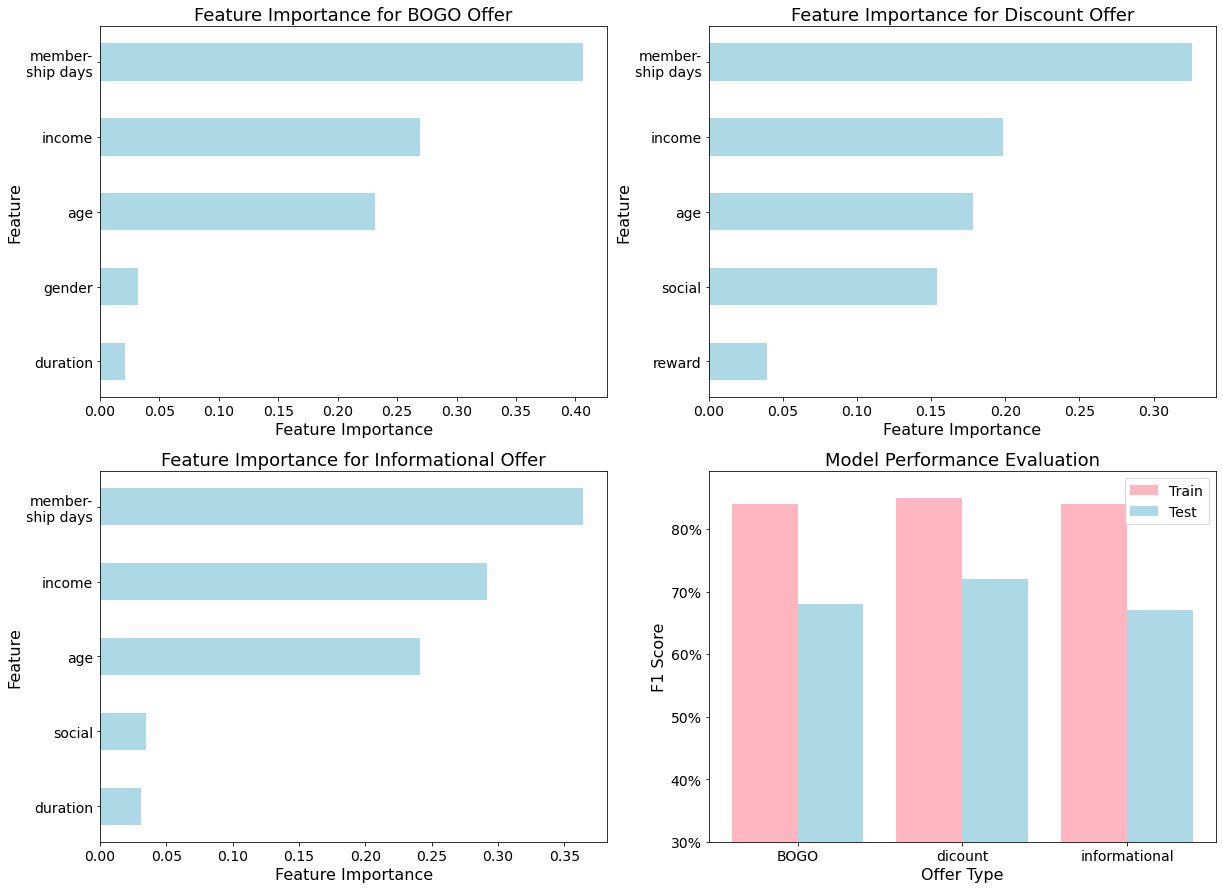

In [62]:
# plot the feature importance
fig = plt.figure(figsize = (20, 15))
axs = []

axs.append(fig.add_subplot(221))
axs[0].barh(['duration', 'gender', 'age', 'income', 'member-\nship days'], bogo_feat_df['importance'], 
            height = 0.5, color = 'lightblue')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Feature Importance', fontsize = 16)
plt.ylabel('Feature', fontsize = 16)
plt.title('Feature Importance for BOGO Offer', fontsize = 18)

axs.append(fig.add_subplot(222))
axs[1].barh(['reward', 'social', 'age', 'income', 'member-\nship days'], discount_feat_df['importance'], 
            height = 0.5, color = 'lightblue')
plt.xlabel('Feature Importance', fontsize = 16)
plt.ylabel('Feature', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('Feature Importance for Discount Offer', fontsize = 18)

axs.append(fig.add_subplot(223))
axs[2].barh(['duration', 'social', 'age', 'income', 'member-\nship days'], info_feat_df['importance'], 
            height = 0.5, color = 'lightblue')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Feature Importance', fontsize = 16)
plt.ylabel('Feature', fontsize = 16)
plt.title('Feature Importance for Informational Offer', fontsize = 18)

# plot the training and test accuracy of the classifiers
axs.append(fig.add_subplot(224))
report = dict({'Type': ['BOGO', 'dicount', 'informational'],
              'Training F1 Score': [84, 85, 84],
              'Test F1 Score': [68, 72, 67]})
x_axis = np.arange(len(report['Type']))
axs[3].bar(x_axis-0.2, report['Training F1 Score'], width = 0.4, label = 'Train', color = 'lightpink')
axs[3].bar(x_axis+0.2, report['Test F1 Score'], width = 0.4, label = 'Test', color = 'lightblue')
axs[3].set_ylim(ymin = 30)
axs[3].yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(fontsize = 14, title_fontsize = 14)
plt.xticks(x_axis, report['Type'], fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Offer Type', fontsize = 16)
plt.ylabel('F1 Score', fontsize = 16)
plt.title('Model Performance Evaluation', fontsize = 18)

plt.show()

It turns out that the number of days being a member, the income and the age of the customers are the most predictive features for all types of offer. So let's further look at how the distribution of these three features differs for the completed offers and not-completed offers.

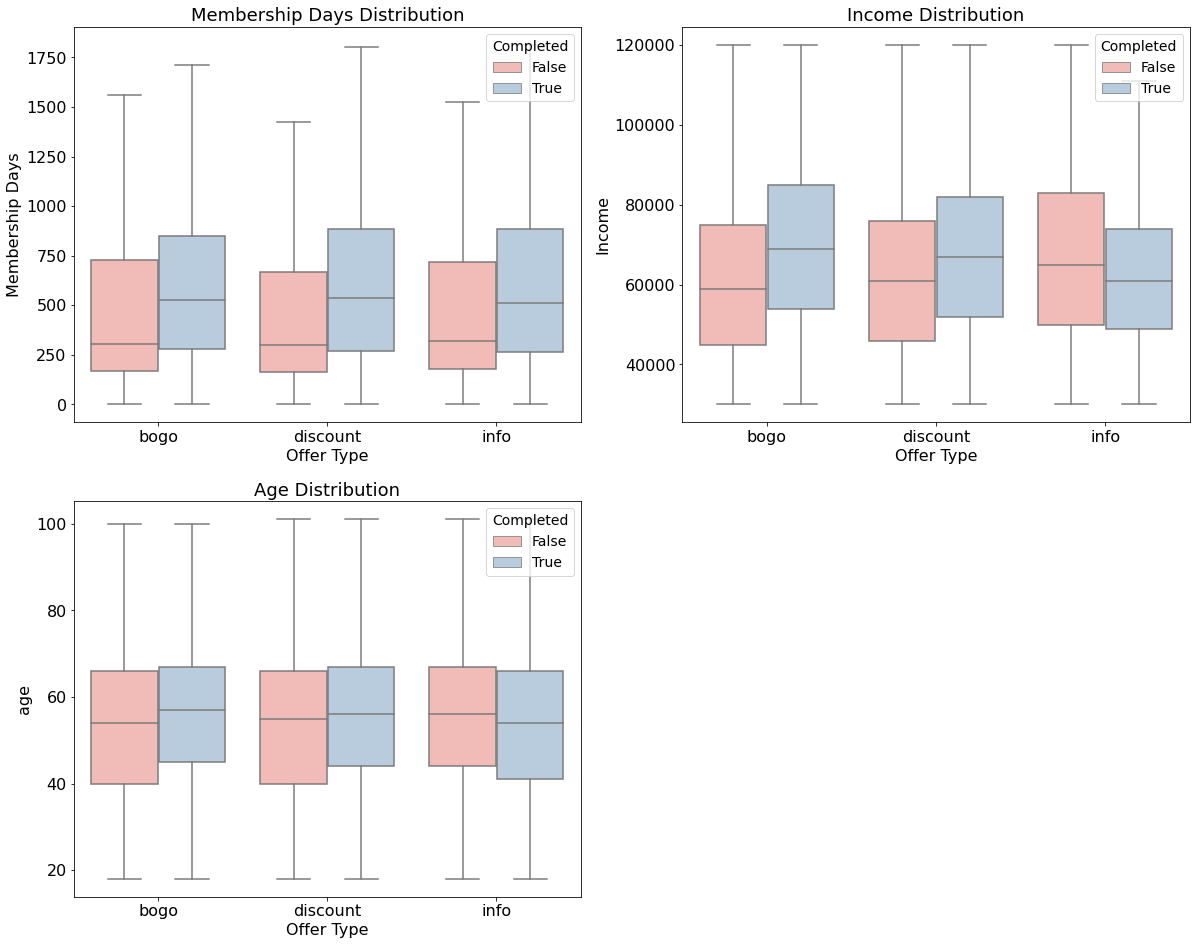

In [63]:
# plot the distribution of membership length, income and age of customers
fig = plt.figure(figsize = (20, 16))
axs = []
bogo_sub = bogo[['membership days', 'income', 'age', 'completed']]
bogo_sub['type'] = 'bogo'

discount_sub = discount[['membership days', 'income', 'age', 'completed']]
discount_sub['type'] = 'discount'

info_sub = info[['membership days', 'income', 'age', 'completed']]
info_sub['type'] = 'info'

offers_sub = pd.concat([bogo_sub, discount_sub, info_sub])
offers_sub['completed'] = offers_sub['completed'].astype(bool)

# plot the distribution of the membership days
axs.append(fig.add_subplot(221))
axs[0] = sns.boxplot(x = 'type', y = 'membership days', hue = 'completed', showfliers = False,
                    data = offers_sub, palette = 'Pastel1')
axs[0].legend(title = 'Completed', loc = 'upper right', fontsize = 14, title_fontsize = 14)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel('Offer Type', fontsize = 16)
plt.ylabel('Membership Days', fontsize = 16)
plt.title(label = 'Membership Days Distribution', fontsize = 18)

# plot the distribution of the income
axs.append(fig.add_subplot(222))
axs[1] = sns.boxplot(x = 'type', y = 'income', hue = 'completed', showfliers = False,
           data = offers_sub, palette = 'Pastel1')
axs[1].legend(title = 'Completed', loc = 'upper right', fontsize = 14, title_fontsize = 14)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel('Offer Type', fontsize = 16)
plt.ylabel('Income', fontsize = 16)
plt.title(label = 'Income Distribution', fontsize = 18)

# plot the distribution of the age
axs.append(fig.add_subplot(223))
axs[2] = sns.boxplot(x = 'type', y = 'age', hue = 'completed', showfliers = False,
                    data = offers_sub, palette = 'Pastel1')
axs[2].legend_.texts[0].set_text('F')
axs[2].legend(title = 'Completed', loc = 'upper right', fontsize = 14, title_fontsize = 14)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel('Offer Type', fontsize = 16)
plt.ylabel('age', fontsize = 16)
plt.title(label = 'Age Distribution', fontsize = 18)

# axs.append(fig.add_subplot(224))
# axs[3] = sns.boxplot(x = 'Income Level', y = 'amount', hue = 'type', showfliers = False,
#            data = profile_sub_type, palette = 'Pastel1')
# plt.legend(title = 'Have Offer or Not', loc = 'upper right', fontsize = 14, title_fontsize = 14)
# plt.xticks(fontsize = 16)
# plt.yticks(fontsize = 16)
# plt.xlabel('Income Level', fontsize = 16)
# plt.ylabel('Transaction Amount', fontsize = 16)
# plt.title(label = 'Transaction Amount Distribution', fontsize = 18)

plt.show()

The results show that the customers with longer seniority of membership are more likely to complete the offers they receive than those with shorter membership terms. This difference is slightly smaller for the informational offers. In terms of income, customers with higher income tend to complete BOGO offers and discount offers rather than informational offers, as shown in the second plot. The age distribution across completed and not-completed offers has less difference than membership and income. The overall age of those who complete BOGO and discount offers tends to be higher than those who do not. However, the younger group of customers is more likely to complete informational offers than the elder group.

## Conclusion

The project conducts qualitative and quantitative analysis of the customer's response to BOGO, discount and informational offers. The results reveal insights that can be considered when send out new offers:

- BOGO and discount offers are likely to get more response/completion from customers with longer membership, customers with higher income, and older customer groups. 
- Informational offers tend to get more response/completion from customers with longer membership, customers with lower income, and younger customer groups.
- The marginal improvement of the amount spent at Starbucks promoted by the offers is higher for the customers with lower income.

There is still a large field that can be studied based on the simulated data. Due to time and effort limitation, I didn't analyze how sending out offers through different channels affect the responses from different customer groups. Also, the machine learning model can be further improved by trying other algorithms and more sets of hyperparameter values.